# Review of some of the data of the exploration of the paramter space.

In [2]:
import lammps2d as lmp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import matplotlib.collections as clt
import pandas as pd
import string as st
import scipy.spatial as spp
import scipy.optimize as spo
import sympy as smp
import copy as cp
import pickle
import os
import sys
import re

from IPython.display import HTML, clear_output

smp.init_printing()
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
dirc = "Z:/SimulationsOfDimerSystem/NematicPhase/ParameterSpace_T300K/"

In [4]:
base_names = [os.path.join(root,os.path.splitext(file)[0]) 
              for root, dirs, files in os.walk(dirc) 
              for file in files 
              if file.endswith(".p")]

In [5]:
def param_from_name(name):
    random = bool(re.findall(r'(?<=rand)\d',name)[0])
    height = float(re.findall(r'(?<=H)\d?[\.]?\d',name)[0])
    packing = float(re.findall(r'(?<=p)\d?[\.]?\d\d',name)[0])
    field = float(re.findall(r'(?<=field_)\d?\d',name)[0])
    return random, height, packing, field

In [6]:
params = [param_from_name(name)+(name,) for name in base_names]

In [7]:
experiments = pd.DataFrame(params,columns=["random","height","packing","field","name"])

In [8]:
def strict_dimers(dim):
    """ Marks those dimers that are not strict as non_strict. """
    idx = pd.IndexSlice

    frames = dim.index.get_level_values("frame").unique().values
    dim_ids = dim.loc[idx[frames[::]]].index.get_level_values("id").unique().values

    not_strict = np.array([],dtype=[("frame",'i'),("id",'f')])

    for i,d_id in enumerate(dim_ids):
        
        members = dim.loc[idx[:,d_id],"members"].iloc[0]
        
        """ timespan is the set of frames where the dimer d_id exists""" 
        timespan = dim.loc[idx[:,d_id],:].index.get_level_values("frame").unique().values
        """ coexisting is an array of all the dimers that exist in the same timespan"""
        coexisting = dim.loc[idx[tuple(timespan),np.delete(dim_ids,i)],"members"]
        
        third_neighbors = np.array([index for dimer,index in zip(coexisting,coexisting.index) 
                                    if bool(dimer.intersection(members))],dtype=[("frame",'i'),("id",'f')])
        
        not_strict = np.append(not_strict,third_neighbors)

    not_strict = pd.DataFrame(not_strict)
    not_strict = not_strict.set_index(["frame","id"])

    dim["strict"] = True
    dim.loc[dim.index.intersection(not_strict.index),'strict']=False
    
    return dim

In [9]:
def count_strict_end(file):
    clear_output(wait=True)
    print("processing ", file)
    sim = pickle.load(open(file+".p", "rb" ))
    trj = lmp.trj_lazyread(file+".lammpstrj")[-1]
    dim = lmp.dimers(trj, sim, distance=3)
    dim = lmp.dimers_findpositions(dim,trj,sim)
    strict_dimers(dim)
    return sum(dim.strict.values)

In [ ]:
S = [count_strict_end(name) for name in experiments.name]

In [ ]:
idx = pd.IndexSlice
experiments.loc[idx[:,"NumberOfDimers"]]=S
experiments.to_csv("DimerCount_singleframe_ParamSweep.dat",sep="\t")

In [13]:
experiments = pd.read_csv("DimerCount_singleframe_ParamSweep.dat",sep="\t")

In [14]:
max_dimers = experiments.iloc[experiments.groupby(['height', 'packing']).NumberOfDimers.idxmax()]

In [17]:
max_dimers.head()

,Unnamed: 0,random,height,packing,field,name,NumberOfDimers
10,10,True,3.8,0.17,1.0,Z:/SimulationsOfDimerSystem/NematicPhase/Param...,0
280,280,True,3.8,0.22,1.0,Z:/SimulationsOfDimerSystem/NematicPhase/Param...,0
420,420,True,3.8,0.27,9.0,Z:/SimulationsOfDimerSystem/NematicPhase/Param...,0
50,50,True,3.8,0.32,1.0,Z:/SimulationsOfDimerSystem/NematicPhase/Param...,3
380,380,True,3.8,0.37,1.0,Z:/SimulationsOfDimerSystem/NematicPhase/Param...,3


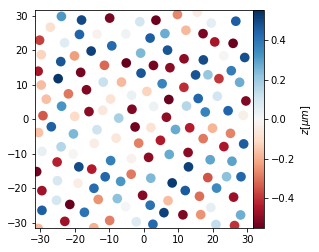

In [28]:
fig,axs = plt.subplots(1,1)
lmp.draw_trj(trj,sim,ax=axs,labels=False)

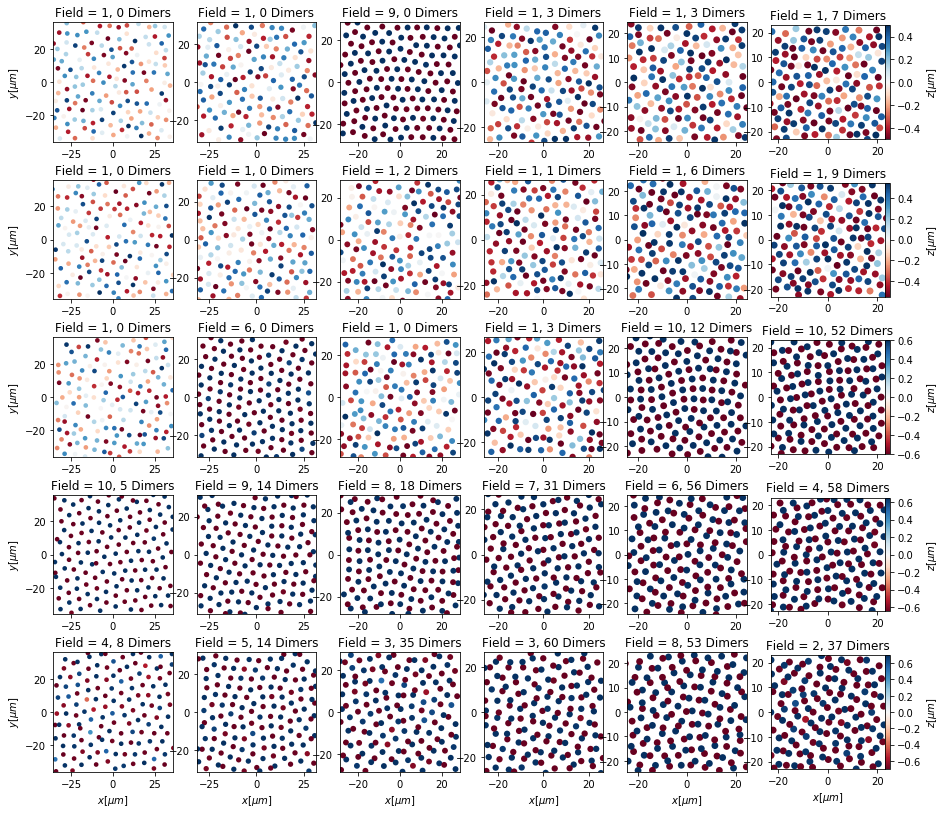

In [29]:
heights = max_dimers.height.unique()
fractions = max_dimers.packing.unique()

fig, axs = plt.subplots(len(heights),len(fractions),figsize=(15,14))

for i,f in enumerate(fractions):
    for j,h in enumerate(heights):
        file = max_dimers[(max_dimers.height==h) & (max_dimers.packing==f)].name.values[0]
        sim = pickle.load(open(file+".p", "rb" ))
        trj = lmp.trj_lazyread(file+".lammpstrj")[-1]
        lmp.draw_trj(trj,sim,ax=axs[j,i],colorbar=(f==fractions[-1]),labels=False)
        if h==heights[-1]:
            axs[j,i].set_xlabel("$x [\mu{m}]$")
        if f==fractions[0]:
            axs[j,i].set_ylabel("$y [\mu{m}]$")
        axs[j,i].set_title("Field = %u, %u Dimers"%
                 (max_dimers[(max_dimers.height==h) & (max_dimers.packing==f)].field,
                  max_dimers[(max_dimers.height==h) & (max_dimers.packing==f)].NumberOfDimers))